## ARIMA

Let's illustrate ARIMA modeling using Dow Jones Indices time series dataset (DJIA) from 2016.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

In [4]:
djia_df = pd.read_excel('Data/DJIA_Jan2016_Dec2016.xlsx', parse_dates=True, index_col=0)
djia_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [5]:
djia_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 6 columns):
Open         252 non-null float64
High         252 non-null float64
Low          252 non-null float64
Close        252 non-null float64
Adj Close    252 non-null float64
Volume       252 non-null int64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


In [6]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=50, ax=ax_acf)
    plot_pacf(xt, lags=50, ax=ax_pacf)
    plt.tight_layout()
    return None

* The DJIA dataset with its basic ACF and PACF plots are as below:

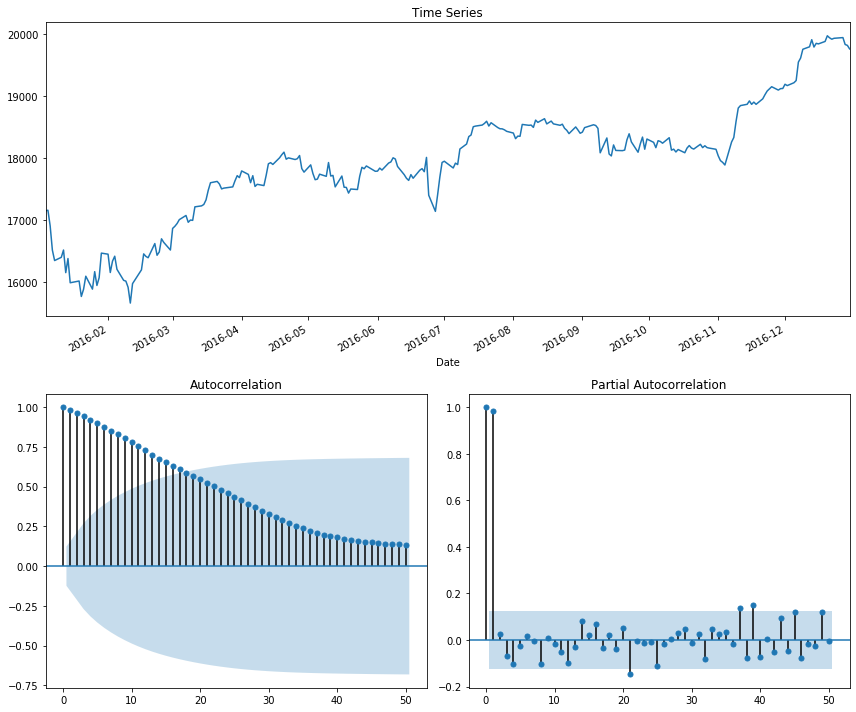

In [7]:
plotds(djia_df['Close'], nlag=50)

* The dataset clearly shows a non-stationary signal with an increasing trend. The ACF is also
showing an exponential decay while PACF has a strong correlation in lag 2. The nonstationarity
can also be checked by evaluating mean and variance in different time periods.
The difference in mean and variance validates the hypothesis of non-stationarity. For
example, we split the DJIA dataset into two semesters from Jan-June 2016 and July-
December 2016 and evaluate the mean and variance as follows:

In [8]:
# Evaluate mean and variance at mid values
mean1, mean2 =djia_df.iloc[:125].Close.mean(), djia_df.iloc[125:].Close.mean()
var1, var2 = djia_df.iloc[:125].Close.var(), djia_df.iloc[125:].Close.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=17226.579164, mean2=18616.603593
variance1=487045.734003, variance2=325183.639530


* The evaluated mean and variance for both semesters show significant difference in mean
and variance values, thus suggesting that the data is non-stationary.
* Another way to evaluate the non-stationarity is using statistical tests such as the Augmented Dickey-Fuller (ADF) test. The ADF is a unit root test that evaluates the strength of trend in a time series component. the null hypothesis is the presence of the unit root or non-stationarity whereas the alternate hypothesis suggests stationarity of the data.



In [9]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
adf_result= adfuller(djia_df.Close)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -0.462320
p-value: 0.899162


* For the given dataset, as p-value is quite high, we cannot reject the NULL hypothesis making it a non-stationary signal. Most of the packages ensure stationarity is satisfied before executing the models. The qqplot to visualize normality for the DJIA dataset is below:

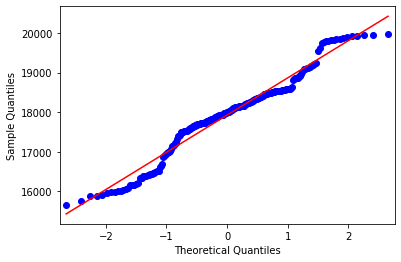

In [10]:
import statsmodels.api as sm

# QQ plot and probability plot
sm.qqplot(djia_df['Close'], line='s')

plt.show()

* It shows significant non-normality within the DJIA dataset. Most of the core packages written in Python check for the stationarity within a dataset. In case stationarity is not satisfied, an error is raised. Let's try to force fit an ARMA(1,1) model on the current dataset:

In [13]:
import statsmodels.tsa.api as smtsa

# Optimize ARMA parameters (Will return a non-stationary error)
arma_obj = smtsa.ARMA(djia_df['Close'], order=(1, 1)).fit(maxlag=30, method='mle', trend='nc')

C:\Anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

* Differencing will help make the signal stationary:

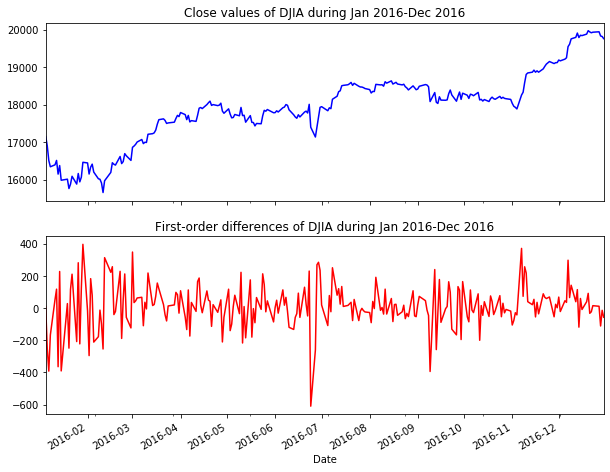

In [18]:
#Let us plot the original time series and first-differences
first_order_diff = djia_df['Close'].diff(1).dropna()
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(10,8)
djia_df['Close'].plot(ax=ax[0], color='b')
ax[0].set_title('Close values of DJIA during Jan 2016-Dec 2016')
first_order_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-order differences of DJIA during Jan 2016-Dec 2016')

plt.show()

* The ACF and PACF chart for an integrated signal with d=1 is shown below:

ADF Statistic: -17.135094
p-value: 0.000000


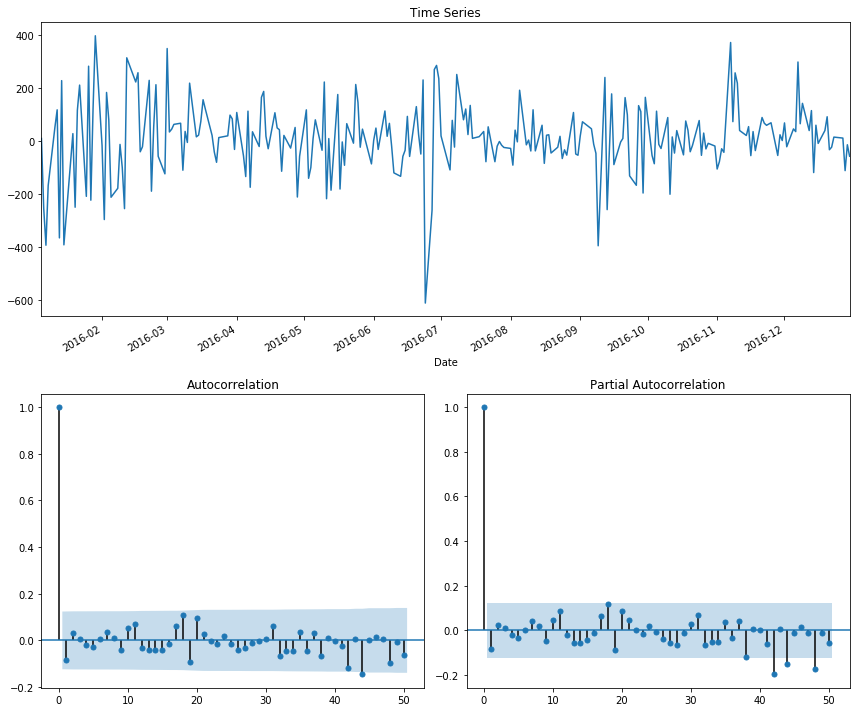

In [20]:
# plot signal
plotds(first_order_diff, nlag=50)
adf_result= adfuller(first_order_diff)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

* The ADF statistics on residual have a value of -17.13 with p-val close to zero, thus stating
that the model is stationary; however, both ACF and PACF show not much of trend of the
moving average component showing a random walk behavior. Also, another way to run is
to optimize using AIC as a criteria:

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Optimize ARMA parameters
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(djia_df['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic, arima_obj_fit.bic])
            except ValueError:
                pass

In [42]:
opt = pd.DataFrame(aicVal, columns=["AR(p)", "d", "MA(q)", "AIC", "BIC"], index=range(1,19))
opt.sort_values("BIC")

,AR(p),d,MA(q),AIC,BIC
11,0,2,1,3177.769461,3188.333844
1,0,1,0,3182.635727,3189.686633
14,1,2,1,3177.995292,3192.081135
12,0,2,2,3178.092457,3192.178301
4,1,1,0,3182.837153,3193.413512
2,0,1,1,3182.931550,3193.507909
17,2,2,1,3179.841307,3197.448612
15,1,2,2,3179.888787,3197.496092
3,0,1,2,3184.662279,3198.764090
7,2,1,0,3184.695359,3198.797170


As AIC between models are very close, it is recommended to use a subject matter expert to
pick the right model. Let's pick ARIMA(0,2,1) for model fitting and evaluation. The
ARIMA(0,2,1) applies second-order differencing and first-order moving average component
to determine the relationship between observations. The model parameter is set up as
shown below:

In [44]:
# Optimal ARIMA model
arima_obj = ARIMA(djia_df['Close'].tolist(), order=(0,2,1))
arima_obj_fit = arima_obj.fit(disp=0)
arima_obj_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  250
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1585.885
Method:                       css-mle   S.D. of innovations            136.122
Date:                Tue, 31 Mar 2020   AIC                           3177.769
Time:                        11:27:15   BIC                           3188.334
Sample:                             2   HQIC                          3182.021
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1011      0.119      0.853      0.394      -0.131       0.334
ma.L1.D2.y    -1.0000      0.012    -81.004      0.000      -1.024      -0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [45]:
# Evaluate prediction
pred=np.append([0,0],arima_obj_fit.fittedvalues.tolist())
djia_df['ARIMA']=pred
diffval=np.append([0,0], arima_obj_fit.resid+arima_obj_fit.fittedvalues)
djia_df['diffval']=diffval

* The comparison with the actual and forecasted values is obtained and visualized below:

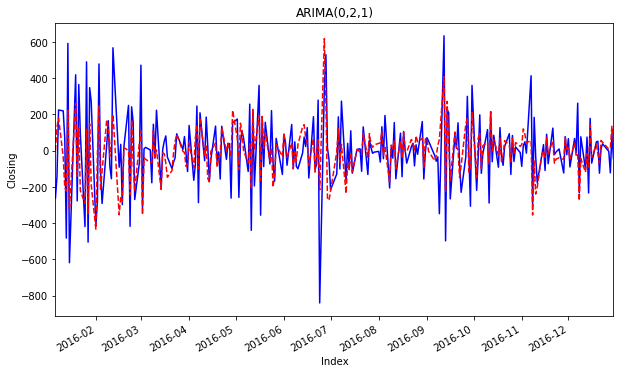

In [50]:
# Plot output
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(10,6)
djia_df['diffval'].iloc[2:].plot(color='b', linestyle = '-', ax=axarr)
djia_df['ARIMA'].iloc[2:].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(0,2,1)')
plt.xlabel('Index')
plt.ylabel('Closing')

plt.show()

* Another critical check of whether the model is optimally built is white noise, such as the
behavior of an error can be observed using qqplot, as shown

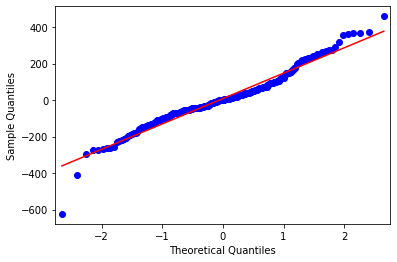

In [53]:
# QQ plot and probability plot
sm.qqplot(arima_obj_fit.resid, line='s')

plt.show()

* The QQ-normality plot with the ARIMA(0,2,1) model shows significant normality fit, as shown above.

#### SARIMAX

* The further extension of the ARIMA model includes the seasonality component for AR, I,
and MA represented in capitals. The seasonal ARIMA is represented as ARIMA(p,d,q) (P, D,
Q)m, where P, D, and Q represent the seasonal part of auto-regressive, integrated, and
moving average, respectively. The m in the seasonal ARIMA model represents the number
of periods per season.

* In scenarios when seasonality is present, the extra steps of seasonal
difference and seasonal adjustment may be required to ensure that the signal is stationary.
For example, if you look at DJIA difference ACF and PACF plots shown in Figure 4.30, the
autocorrelation becomes slightly significant at 42 index, which means that there may be
seasonality present. The seasonality present on first difference and can be seen using the
following lines of code:

In [57]:
# Seasonality (based on first difference ACF shows significance at 42 lag)
x=djia_df['Close']-djia_df['Close'].shift(42)
mod = sm.tsa.statespace.SARIMAX(djia_df['Close'].to_list(), trend='n', order=(0,2,1), seasonal_order=(1,1,1,42))
sarimax= mod.fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  252
Model:             SARIMAX(0, 2, 1)x(1, 1, 1, 42)   Log Likelihood               -1366.570
Date:                            Tue, 31 Mar 2020   AIC                           2741.141
Time:                                    12:53:35   BIC                           2754.491
Sample:                                         0   HQIC                          2746.539
                                            - 252                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     16.161     -0.062      0.951     -32.675      30.675
ar.S.L42      -0.2542      0.093     -2.727      0.006      -0.437      -0.072
ma.S.L42      -0.4671      0.130     -3.597      0.000      -0.722      -0.213
sigma2      2.355e+04    3.8e+05      0.062      0.951   -7.22e+05    7.69e+05
===================================================================================
Ljung-Box (Q):                       31.80   Jarque-Bera (JB):                21.28
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* The model shows significant improvement in terms of AIC and can be further optimized for
different components involved in the SARIMAX model.

### Confidence interval

The confidence interval with an alpha value 0.05 for the DJIA dataset modeled
using the ARIMA(0,2,1) model can be obtained using the forecast function from the
arima_obj_fit object:

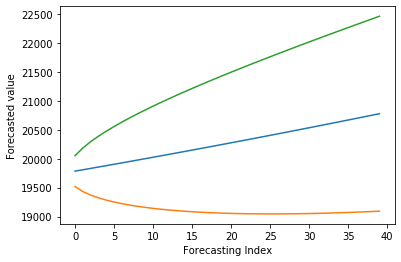

In [68]:
# Forecasting and CI
f, err, ci=arima_obj_fit.forecast(40)
plt.plot(f)
plt.plot(ci)
plt.xlabel('Forecasting Index')
plt.ylabel('Forecasted value')

plt.show()

Source: Practical Time Series Analysis - Dr. Avishek Pal, Dr. PKS Prakash